In [75]:
import os
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.tools import Tool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [5]:
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embeddings = HuggingFaceEmbeddings()
vectorstore = FAISS.from_documents(chunks , embeddings)
retriever = vectorstore.as_retriever()

In [6]:
retriever.invoke("what are agents")

[Document(id='2b23856e-b679-4794-be86-2aae312e60b8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [7]:
def retriever_tool_func(query: str) -> str:
    print("Using Rag tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [8]:
retriever_tool_func("what are agents")

Using Rag tool


'}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations:\n},\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide more information about how the MVC components are split into separate files?"\n  },\n  {\n    "role": "user",\n    "content": "{{Make your own assumptions and state them explicitly before starting}}"\n  }\n]\nThen after these clarification, the agent moved into the code writing mode with a different system message.\nSystem message:\nGenerative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agen

In [9]:
retriever_tool =Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
)

retriever_tool

Tool(name='RAGRetriever', description='Use this tool to fetch relevant knowledge base info', func=<function retriever_tool_func at 0x00000129BD769120>)

In [10]:
wiki_tools = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tools

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'e:\\agenticaiworkspace\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [11]:
import os
from dotenv import load_dotenv
from langgraph.prebuilt import create_react_agent 


from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="openai/gpt-oss-120b")

D:\temp\ipykernel_174356\2804394664.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node = create_react_agent(llm,tools)


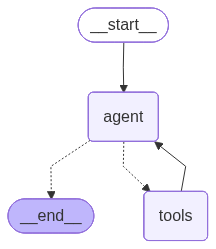

In [12]:
tools =[retriever_tool,wiki_tools]

react_node = create_react_agent(llm,tools)
#react_node= create_agent(llm,tools)
react_node

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

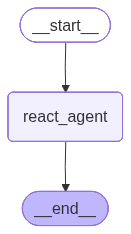

In [14]:
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)
graph = builder.compile()
graph

In [15]:

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)


✅ Final Answer:
 ### What an “agent loop” is  

In the field of artificial‑intelligence and software agents, an **agent loop** (sometimes called a *perception‑action cycle* or *sense‑think‑act loop*) is the repetitive process that an autonomous system follows in order to operate in its environment. The loop can be broken down into a few canonical steps:

| Step | What happens | Typical implementation |
|------|--------------|------------------------|
| **1. Perceive / Sense** | The agent gathers data from its surroundings (e.g., via sensors, APIs, web scrapes, user input). | Reading a camera frame, querying a database, listening to a message queue. |
| **2. Interpret / Update State** | Raw observations are transformed into an internal representation (state) that the agent can reason about. | Feature extraction, updating a belief‑state, building a world model. |
| **3. Decide / Plan** | Using its current state, goals, and possibly a learned model, the agent selects a next action or a s

In [77]:

import os
from typing import Annotated, Sequence, TypedDict
from langchain_community.tools import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader
from langchain_community.tools import ArxivQueryRun

In [17]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000129BF951160>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000129BF951E80>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [80]:
#function to create retriever tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50).split_documents(docs)
    vs =  FAISS.from_documents(chunks,HuggingFaceEmbeddings())
    retriever = vs.as_retriever()
    
    
    def tool_func(query:str) -> str:
        print(f" Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name, description=desc, func=tool_func)

# Wikipedia Tool


wiki_tool = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(),
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia."
)

# ArXiv Tool
arxiv_tool = ArxivQueryRun(
    api_wrapper=ArxivAPIWrapper(),
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    
)

wiki_tool
arxiv_tool

ArxivQueryRun(name='ArxivSearch', description='Use this tool to fetch recent academic papers on technical topics.', api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000))

arxiv


In [53]:
internal_tool_1 = make_retriever_tool_from_text(
    "sample_docs.txt",
    "SampleTechDocs",
    "Search sample tech documents for proprietary architecture and methods."
    
    
    
)
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
    
)

internal_tool_2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000129D630C040>)

In [69]:
import fitz
print(fitz.__file__)


e:\agenticaiworkspace\.venv\Lib\site-packages\fitz\__init__.py


In [58]:
from pydantic import BaseModel
from langchain_community.tools import Tool

class InternalResearchNotesInput(BaseModel):
    query: str


base_tool = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)

def internal_research_notes(query: str) -> str:
    return base_tool.run(query)

internal_tool_2 = Tool(
    name="InternalResearchNotes",
    description="Search internal research notes for experimental results and agent designs.",
    func=internal_research_notes,
    args_schema=InternalResearchNotesInput
)


base_tool_1 = make_retriever_tool_from_text(
    "sample_docs.txt",
    "SampleTechDocs",
    "Search sample tech documents for proprietary architecture and methods."
)

class SampleTechDocsInput(BaseModel):
    query: str
    
def sample_tech_docs(query: str) -> str:
    return base_tool_1.run(query)

internal_tool_1 = Tool(
    name="SampleTechDocs",
    description="Search sample tech documents for proprietary architecture and methods.",
    func=sample_tech_docs,
    args_schema=SampleTechDocsInput
)

D:\temp\ipykernel_174356\1404938843.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node= create_react_agent(llm,tools)


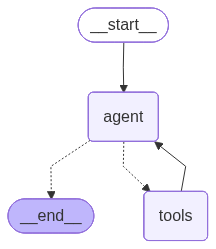

In [81]:
tools = [wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node= create_react_agent(llm,tools)
react_node

internal_tool_1
internal_tool_2

In [82]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]



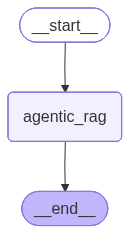

In [83]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph

In [85]:
query = "What do our research notes say about transformer variants?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

 Using tool: InternalResearchNotes

✅ Final Answer:
 **Summary of Internal Research Notes on Transformer Variants (July 2024)**  

| Variant | Primary Use‑Case Tested | Key Performance Numbers | Memory / Compute Characteristics | Strengths | Weaknesses / Open Issues | Recommendations |
|---------|------------------------|--------------------------|----------------------------------|-----------|--------------------------|-----------------|
| **EfficientFormer** | Image classification on TinyImageNet (edge deployment) | Top‑1 = 92.4 % (batch = 16) | Peak RAM ≈ 290 MB on a Raspberry Pi 4 | • Very low‑footprint while retaining high accuracy<br>• Quantises cleanly to int8 with < 1 % drop | • Limited to relatively small image resolutions; scaling to larger vision tasks not yet explored | Use for on‑device vision models where latency < 50 ms and memory budget ≈ 300 MB. |
| **Longformer** | Customer‑support log processing (max tokens = 8192) | Latency ≈ 1.2 s/query (streaming) | Chunk‑based hy

In [73]:
import fitz
print(fitz.__file__)
doc = fitz.open("attention.pdf")
print("PyMuPDF works ✅")

e:\agenticaiworkspace\.venv\Lib\site-packages\fitz\__init__.py
PyMuPDF works ✅


In [74]:
import fitz
print(fitz.__file__)
print(hasattr(fitz, "open"), hasattr(fitz, "fitz"))



e:\agenticaiworkspace\.venv\Lib\site-packages\fitz\__init__.py
True True
